# Лабораторная работа №7: Кластерный анализ. Метод поиска сгущений

Выполнили студентки гр. 8383 Ишанина Людмила и Сырцова Екатерина. Вариант №6.

## Цель работы

Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода поиска сгущений.

## Основные теоретические положения

**Метод поиска сгущений** - итеративный метод кластерного анализа.

**Основная идея метода** заключается в построении гиперсферы заданного радиуса, которая перемещается в пространстве классификационных признаков в поисках локальных сгущений объектов.

**Метод** поиска сгущений **требует**, прежде всего, **вычисления матрицы расстояний** между объектами и **выбора первоначального центра сферы**.
Рассчитаем расстояния между объектами по евклидовой метрике
$$d_{ij} = \sqrt{\sum_{k=1}^3{(z_k^{(i)}-z_k^{(j)})^2}}$$

**Как правило, на первом шаге** центром сферы служит объект, в ближайщей окрестности которого расположено наибольшее число соседей. На основе заданного радиуса сферы $R$ определяется совокупность точек внутри этой сферы, и для них вычисляются координаты центра (вектор средних для попавших в сферу значений признаков).

**Когда очередной пересчет** координат центра сферы приводит к такому же результату, как и на предыдущем шаге, перемещение сферы прекращается, а точки, попавшие в нее, образуют кластер, и из дальнейшего процесса кластеризации исключаются.

**Перечисленные процедуры повторяются** для всех оставшихся точек. Работа алгоритма завершается за конечное число шагов, и все точки оказываются распределенными по кластерам. Число образовавшихся кластеров заранее не известно и сильно зависит от заданного радиуса сферы.

**Для оценки устойчивости** полученного разбиения целесообразно повторить процесс кластеризации несколько раз для различных значений радиуса сферы, изменяя каждый радиус на небольшую величину.

**Существуют различные способы выбора начального радиуса сферы**. В частности, если обозначить через $d_{ij}$ расстояние между $i$-м и $j$-м объектами, то в качестве нижней границы значения радиуса сферы можно выбрать минимальное из таких расстояний, а в качестве верхней границы - максимальное: $R_{min} = \min_{i,j}{d_{ij}}, R_{max} = \max_{i,j}{d_{ij}}$.

Тогда, если начинать работу алгоритма с $R = R_{min} + \delta, \delta > 0$ и при каждом его повторении увеличивать значение $\delta$ на некоторую величину, то в конечном итоге можно найти значения радиусов, которые приводят к устойчивому разбиению на кластеры.

## Постановка задачи

Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в лабораторной работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода поиска сгущений. Полученные результаты содержательно проинтерпретировать.

### Порядок выполнения работы
1. Нормализовать множество точек, отобразить полученное множество.
2. Реализовать алгоритм поиска сгущений, отобразить полученные кластеры, выделить каждый кластер разным цветом, отметить центроиды.
3. Проверить чувствительность метода к погрешностям. Сделать выводы.
4. Сравнить с методами из лабораторной работы №6. Сделать выводы.

## Выполнение работы

### Нормализация множества точек
Нормализуем множество точек из лабораторной работы №4 по формуле $z = \frac{x}{x_{max}}$ и отобразим полученное множество:

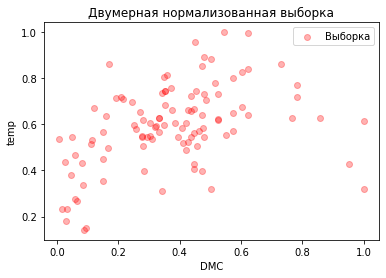

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('forestfires_105.csv', usecols=['DMC', 'temp'], sep=',')

data_DMC = data.loc[:,['DMC']]
ranked_DMC = data_DMC.sort_values(by='DMC')
k = 1 + math.floor(3.322 * math.log10(ranked_DMC.size))
h_DMC = (ranked_DMC['DMC'].max() - ranked_DMC['DMC'].min()) / k
points = np.concatenate((np.arange(ranked_DMC['DMC'].min(), ranked_DMC['DMC'].max(), h_DMC), [ranked_DMC['DMC'].max()]))
interval_DMC = ranked_DMC.groupby(pd.cut(ranked_DMC['DMC'], points)).size().reset_index(name='frequency')
interval_DMC['frequency'][0] += 1
table_DMC = pd.DataFrame()
table_DMC['DMC'] = interval_DMC['DMC']
table_DMC['x_i'] = interval_DMC['DMC'].apply(lambda x: x.mid).astype('float')
table_DMC['n_i'] = interval_DMC['frequency']
center_DMC = table_DMC['x_i'][math.floor(k / 2)]
table_DMC['u_i'] = table_DMC['x_i'].apply(lambda x: (x - center_DMC) / h_DMC)
table_DMC['n_cum'] = np.cumsum(interval_DMC['frequency'])

data_temp = data.loc[:,['temp']]
ranked_temp = data_temp.sort_values(by='temp')
k = 1 + math.floor(3.322 * math.log10(ranked_DMC.size))
h_temp = (ranked_temp['temp'].max() - ranked_temp['temp'].min()) / k
points = np.concatenate((np.arange(ranked_temp['temp'].min(), ranked_temp['temp'].max(), h_temp), [ranked_temp['temp'].max()]))
interval_temp = ranked_temp.groupby(pd.cut(ranked_temp['temp'], points)).size().reset_index(name='frequency')
interval_temp['frequency'][0] += 1
table_temp = pd.DataFrame()
table_temp['temp'] = interval_temp['temp']
table_temp['x_i'] = interval_temp['temp'].apply(lambda x: x.mid).astype('float')
table_temp['n_i'] = interval_temp['frequency']
center_temp = table_temp['x_i'][math.floor(k / 2)]
table_temp['u_i'] = table_temp['x_i'].apply(lambda x: (x - center_temp) / h_temp)
table_temp['n_cum'] = np.cumsum(interval_temp['frequency'])

data_DMC['DMC'] /= max(data_DMC['DMC'])
data_temp['temp'] /= max(data_temp['temp'])

plt.scatter(data_DMC['DMC'], data_temp['temp'], color = 'red', marker = 'o', alpha = 0.3, label = 'Выборка')
plt.xlabel('DMC')
plt.ylabel('temp')
plt.title('Двумерная нормализованная выборка')
plt.legend()
plt.show()

### Алгоритм поиска сгущений

Вычислим матрицу расстояний $D$ между объектами, в качестве нижней границы значения радиуса сферы выберем минимальное из таких расстояний, а в качестве верхней границы - максимальное: $R_{min} = \min_{i,j}{d_{ij}}, R_{max} = \max_{i,j}{d_{ij}}$.

In [2]:
points = np.array([[data_DMC['DMC'][i], data_temp['temp'][i]] for i in range(105)])
D = np.zeros((105, 105))
R_min, R_max = 10, 0
for i in range(105):
    for j in range(105):
        D[i][j] = math.sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
        if (D[i][j] != 0):
            R_min = min(D[i][j], R_min)
            R_max = max(D[i][j], R_max)
print('$R_{min} = $', R_min)
print('$R_{max} = $', R_max)

$R_{min} = $ 0.0030864197530863224
$R_{max} = $ 1.0618908540112424


Метод поиска сгущений реализован с постоянным значением радиуса.
В качетве радиуса сферы $R$ будем принимать значения в интервале $(R_{min},R_{max}) = (0.0030864197530863224; 1.0618908540112424)$ с шагом $\delta = 0.001$, алгоритм повториться примерно 1000 раз.
На первом шаге центром сферы служит объект, в ближайщей окрестности которого расположено наибольшее число соседей. На основе заданного радиуса сферы $R$ определяется совокупность точек внутри этой сферы, и для них вычисляются координаты центра (вектор средних для попавших в сферу значений признаков).
Когда очередной пересчет координат центра сферы приводит к такому же результату, как и на предыдущем шаге, перемещение сферы прекращается, а точки, попавшие в нее, образуют кластер, и из дальнейшего процесса кластеризации исключаются.
Перечисленные процедуры повторяются для всех оставшихся точек.

In [4]:
def get_clusters(points, R, first):
    centers = []
    clusters = []
    i = 0
    while len(points) != 0:
        current = points[np.random.choice(len(points), 1)[0]] if i > 0 else points[first]
        neighbors = np.array([point for point in points if np.linalg.norm(current - point) < R])
        center = np.array([np.mean(neighbors[:, 0]), np.mean(neighbors[:, 1])])
        while np.linalg.norm(current - center) > 1e-19:
            current = center
            neighbors = np.array([point for point in points if np.linalg.norm(current - point) < R])
            center = np.array([np.mean(neighbors[:, 0]), np.mean(neighbors[:, 1])])
        points = del_points(neighbors, points)
        centers.append(current)
        clusters.append(neighbors)
        i += 1
    F1, F2, F3 = 0, 0, 0
    for n in range(len(clusters)):
        F1 += np.sum(np.linalg.norm(clusters[n] - centers[n]) ** 2)
        for i in range(len(clusters[n])):
            for j in range(i, len(clusters[n])):
                F2 += np.linalg.norm(clusters[n][i] - clusters[n][j]) ** 2
        F3 += np.sum(np.std(clusters[n], axis=0))
    return np.array(centers), clusters, [F1, F2, F3]


def del_points(neighbors, points):
    output = []
    for i in points.tolist():
        if i not in neighbors.tolist():
            output.append(i)
    return np.array(output)

In [6]:
table = pd.DataFrame(columns=['R', 'F1', 'F2', 'F3', 'clusters'])
t = 0
center, cluster, Func = [], [], []
for R in np.arange(R_min + 0.001, R_max, 0.001):
    first = 0
    count = 0
    for i in range(105):
        if (len(D[i][D[i] < R]) > count):
            count = len(D[i][D[i] < R])
            first = i
    centers, clusters, F = get_clusters(points, R, first)
    center.append(centers)
    cluster.append(clusters)
    Func.append(F)
    table.loc[t] = [R, F[0], F[1], F[2], len(clusters)]
    t += 1
table

,R,F1,F2,F3,clusters
0,0.004086,0.000010,0.000020,0.003431,102.0
1,0.005086,0.000018,0.000037,0.006354,101.0
2,0.006086,0.000018,0.000037,0.006354,101.0
3,0.007086,0.000038,0.000075,0.009785,100.0
4,0.008086,0.000038,0.000075,0.009785,100.0
...,...,...,...,...,...
1053,1.057086,8.135507,854.228186,0.391714,1.0
1054,1.058086,8.135507,854.228186,0.391714,1.0
1055,1.059086,8.135507,854.228186,0.391714,1.0
1056,1.060086,8.135507,854.228186,0.391714,1.0


По полученным результатам с изменением радиуса на $\delta = 0.001$ найдем устойчивые значения радиусов (значения функционалов при увеличении радиуса на $\delta$ не изменяются). Например для разбиения на 8 кластеров.

In [7]:
table[222:224]

,R,F1,F2,F3,clusters
222,0.226086,1.593848,66.709523,1.070788,8.0
223,0.227086,1.593848,66.709523,1.070788,8.0


Отобразим выбранное разбиение на кластеры.

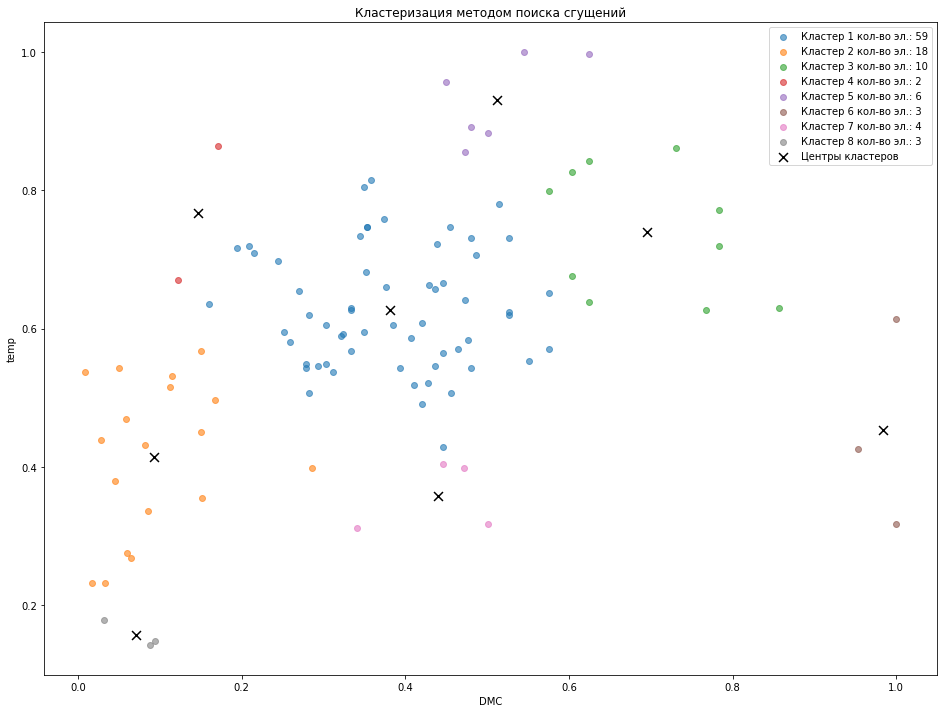

In [8]:
i = 1
fig, ax = plt.subplots()
for c in cluster[222]:
    plt.scatter(c[:, 0], c[:, 1], label='Кластер ' + str(i) + ' кол-во эл.: ' + str(len(c)), marker = 'o', alpha = 0.6)
    i += 1
plt.scatter(center[222][:, 0], center[222][:, 1], color = 'black', marker = 'x', s = 80, label = 'Центры кластеров')
plt.title("Кластеризация методом поиска сгущений")
plt.xlabel('DMC')
plt.ylabel('temp')
plt.legend()
fig.set_figwidth(16)
fig.set_figheight(12)
plt.show()

### Сравнение методов поиска сгущений и k-means

Сравним реализованный метод с методом k-means из лабораторной работы №6.

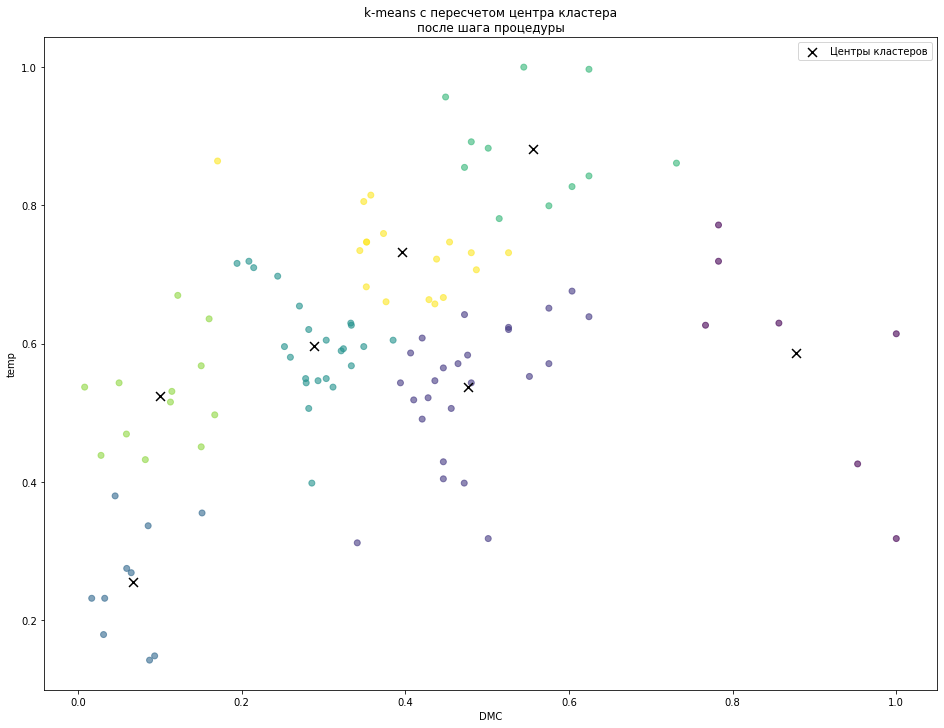

In [22]:
k = math.floor(math.sqrt(105/2))
F = pd.DataFrame(columns=['F1', 'F2', 'F3'])
points = np.array([[data_DMC['DMC'][i], data_temp['temp'][i]] for i in range(105)])
center = points[np.random.permutation(105)[:k]]
f = 1
while True:
    F1, F2, F3 = 0, 0, 0
    C = pairwise_distances_argmin(points, center)
    new_center = np.array([points[C == i].mean(0) for i in range(k)])
    if np.all(center == new_center):
        break
    center = new_center
    for n in range(k):
        F1 += np.sum(np.linalg.norm(points[C == n] - center[n]) ** 2)
        for i in range(len(points[C == n])):
            for j in range(i, len(points[C == n])):
                F2 += np.linalg.norm(points[C == n][i] - points[C == n][j]) ** 2
        F3 += np.sum(np.std(points[C == n], axis=0))
    F.loc[f] = [F1,F2,F3]
    f += 1

idx = 1
fig, ax = plt.subplots()
plt.scatter(points[:, 0], points[:, 1], c = C, marker = 'o', alpha = 0.6)
plt.scatter(center[:, 0], center[:, 1], color = 'black', marker = 'x', s = 80, label = 'Центры кластеров')
plt.title("k-means с пересчетом центра кластера\nпосле шага процедуры")
plt.xlabel('DMC')
plt.ylabel('temp')
plt.legend()
fig.set_figwidth(16)
fig.set_figheight(12)
plt.show()

Функционалы качества метода k-средних:

In [23]:
F

,F1,F2,F3
1,1.908008,32.323017,1.224514
2,1.278966,18.738825,1.102140
3,1.238433,19.071356,1.071802
4,1.221957,19.489078,1.070517
5,1.198315,19.938088,1.059180
6,1.196680,20.166521,1.056358


Функционалы качества метода сгущений:

In [11]:
table[222:224]

,R,F1,F2,F3,clusters
222,0.226086,1.593848,66.709523,1.070788,8.0
223,0.227086,1.593848,66.709523,1.070788,8.0


При разбиении множества точек методом поиска сгущений первый кластер содержит максимальное количество точек в окрестности заданного радиуса, из-за этого количество объектов в остальных кластерах сильно снижается. Наблюдаются пересечения радиусов кластеров, однако алгоритм реализован таким образом, что спорные точки относятся к кластеру, центроид которого имеет наибольшее количество соседей.

При увелиении значения радиуса сферы сумма квадратов расстояний до центов кластеров и сумма внутрикластерных расстояний между объектами увеличивается (объекты попадающие в радиус сферы относятся к первому подходящему кластеру, а в методе k-средних объекты относятся к кластеру, расстояние до центра которого минимальное), а сумма внутрикластерных дисперсий уменьшается. Таких же результатов качества разбиения как в методе k-средних с помощью метода сгущений мы несможем добиться устойчивым разбиением.

В данном случае разбиение с помощью метода поиска сгущений оказалось менее качественным, чем метод k-средних.

## Выводы

В процессе выполнения лабораторной работы были изучены основные понятия и некоторые методы кластерного анализа, в частности метод поиска сгущений. Для реализации метода поиска сгущений были вычислены матрица расстояний, нижняя и верхняя оценка радиуса сферы, функционалы качества разбиения для различных значений радиуса сферы. Было найдено устойчивое разбиение методом поиска сгущений. Определено, что увеличение радиуса сферы приводит к увеличению функционалов качества $F_1, F_2$ и уменьшению $F_3$.